# Бинарная классификация сетевого трафика: безопасный и вирусный.

Требуется определить является ли сетевое взаимодействие опасным/безопасным по большому числу признаков трафика. 

## Подключение модулей

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline              
import pandas as pd
import seaborn as sns
import sklearn

## Исправление проблем датасета
В исходном датасете в заголовках неравномерно стояли пробелы.

In [2]:
# file = open(url, "r")
# data = file.read()
# file.close()
# file = open(url, "w")
# data = f.replace(' ', '')
# file.write(f)
# file.close()

## Загрузка данных

In [3]:
url = './data/dataset.csv'
data = pd.read_csv(url, sep=',', header=0, engine='python')
data.shape

(177482, 85)

Датасет содержит 85 различных признаков, такие как IP, порт, размер пакета, число пакетов, скорость соединения и т.д. Классами являются метки Trojan - вирус и Benign - не вирус. Датасет содержит более 170 000 записей сетевых взаимодействий.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177482 entries, 73217 to 167491
Data columns (total 85 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   FlowID                   177482 non-null  object 
 1   SourceIP                 177482 non-null  object 
 2   SourcePort               177482 non-null  int64  
 3   DestinationIP            177482 non-null  object 
 4   DestinationPort          177482 non-null  int64  
 5   Protocol                 177482 non-null  int64  
 6   Timestamp                177482 non-null  object 
 7   FlowDuration             177482 non-null  int64  
 8   TotalFwdPackets          177482 non-null  int64  
 9   TotalBackwardPackets     177482 non-null  int64  
 10  TotalLengthofFwdPackets  177482 non-null  float64
 11  TotalLengthofBwdPackets  177482 non-null  float64
 12  FwdPacketLengthMax       177482 non-null  float64
 13  FwdPacketLengthMin       177482 non-null  float64
 14  

In [5]:
data.head()

,FlowID,SourceIP,SourcePort,DestinationIP,DestinationPort,Protocol,Timestamp,FlowDuration,TotalFwdPackets,TotalBackwardPackets,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Class
73217,10.42.0.42-121.14.255.84-49975-80-6,10.42.0.42,49975,121.14.255.84,80,6,17/07/201701:18:33,10743584,4,4,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trojan
72089,172.217.6.226-10.42.0.42-443-49169-17,10.42.0.42,49169,172.217.6.226,443,17,17/07/201710:25:25,254217,6,7,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trojan
96676,10.42.0.1-10.42.0.42-53-37749-17,10.42.0.42,37749,10.42.0.1,53,17,30/06/201707:16:12,1023244,1,1,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
42891,10.42.0.1-10.42.0.42-53-41352-17,10.42.0.42,41352,10.42.0.1,53,17,13/07/201703:48:44,286483,1,1,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trojan
169326,10.42.0.151-107.22.241.77-44353-443-6,10.42.0.151,44353,107.22.241.77,443,6,05/07/201710:47:35,65633087,12,10,...,32,322594.0,0.0,322594.0,322594.0,60306983.0,0.0,60306983.0,60306983.0,Benign


In [6]:
data.tail()

,FlowID,SourceIP,SourcePort,DestinationIP,DestinationPort,Protocol,Timestamp,FlowDuration,TotalFwdPackets,TotalBackwardPackets,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Class
40740,10.42.0.42-64.71.142.96-60811-80-6,10.42.0.42,60811,64.71.142.96,80,6,13/07/201703:50:57,40648037,2,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trojan
82587,10.42.0.42-54.192.36.60-33004-80-6,10.42.0.42,33004,54.192.36.60,80,6,17/07/201703:36:20,2037177,2,0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trojan
66647,172.217.9.232-10.42.0.42-443-51049-6,10.42.0.42,51049,172.217.9.232,443,6,14/07/201703:45:27,397316,9,7,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trojan
7987,10.42.0.211-10.42.0.1-9145-53-17,10.42.0.211,9145,10.42.0.1,53,17,11/07/201710:16:27,32073,1,1,...,44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trojan
167491,10.42.0.42-104.254.66.16-47389-80-6,10.42.0.42,47389,104.254.66.16,80,6,05/07/201709:18:02,360889,2,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


## Визуализация и основные характеристики

### Визуализация связей основных характеристик

Характеристик очень много, поэтому визуализирую некоторые из них (на мой взгляд самые очевидные и важные)

Берем рандомное подмножество строк датасета

In [7]:
np.random.seed(123)
random_set = np.random.choice(np.arange(data.shape[0]), size=500)

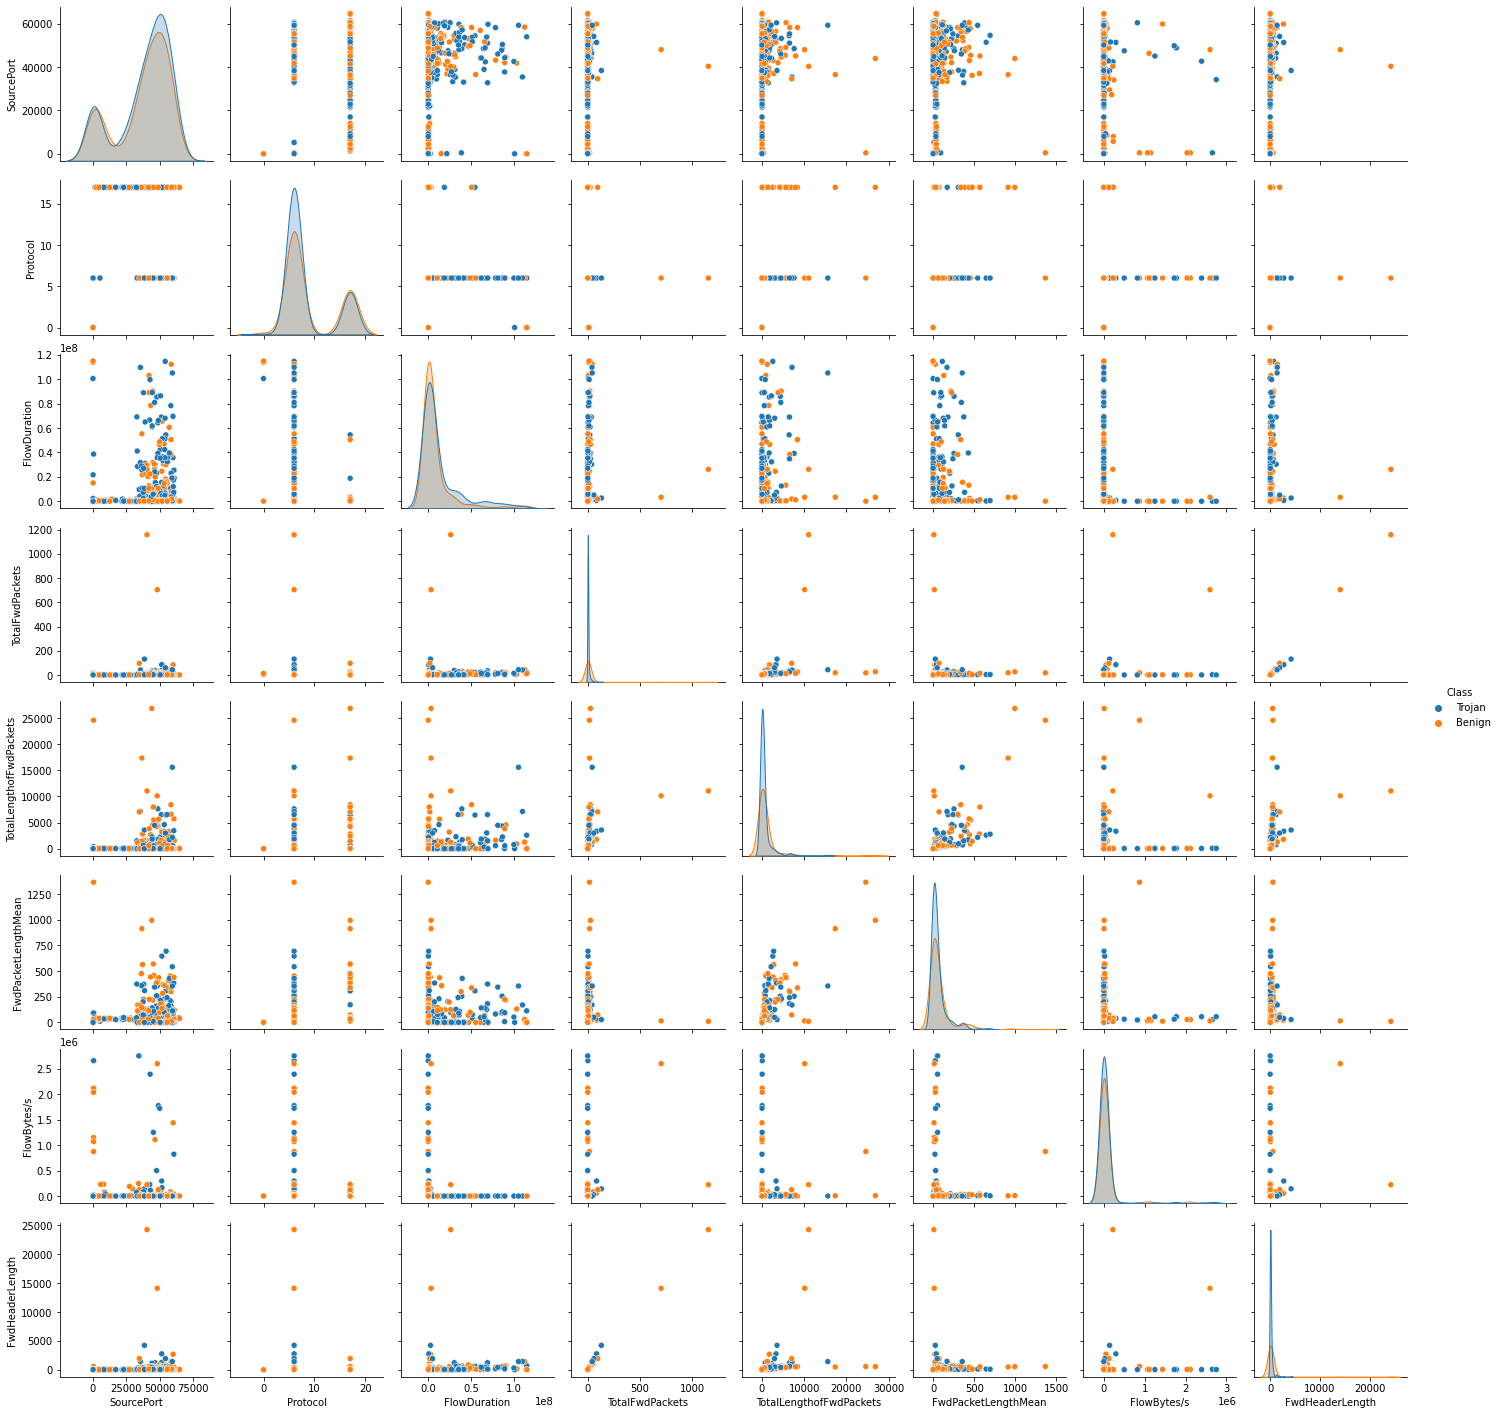

In [8]:
from pandas.plotting import scatter_matrix
headers = ['SourceIP', 'SourcePort', 'Protocol', 'FlowDuration', 'TotalFwdPackets', 'TotalLengthofFwdPackets', 'FwdPacketLengthMean', 'FlowBytes/s', 'FwdHeaderLength', 'Class']
sns.pairplot(data.iloc[random_set][headers], diag_kind = 'auto', hue='Class')
pass

Нетрудно заметить ощутимую зависимость класса от вида протокола, времени его работы и длины пакетов.

### Распределение классов

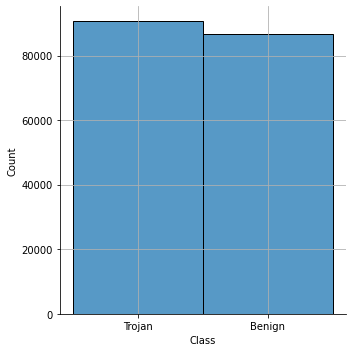

In [9]:
sns.displot(data['Class'], bins=2)
plt.grid()
pass

Можно считать, что классы сбалансированы

### Распределение портов

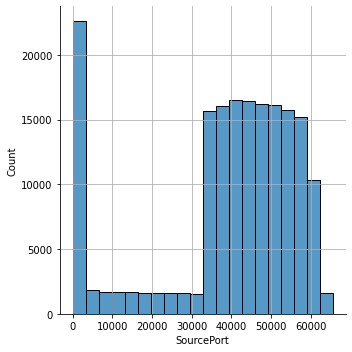

In [10]:
sns.displot(data['SourcePort'], bins=20)
plt.grid()
pass

### Зависимость IP от времени
Изначально я убрал время из датасета. Но как оказалось время сильно повышает точность. Это можно объяснить тем, что атаки совершаются в определенное время или пользователи заходят на опасные ресурсы в какое-то определенное время.  
На осях графика не получается красиво отобразить :(

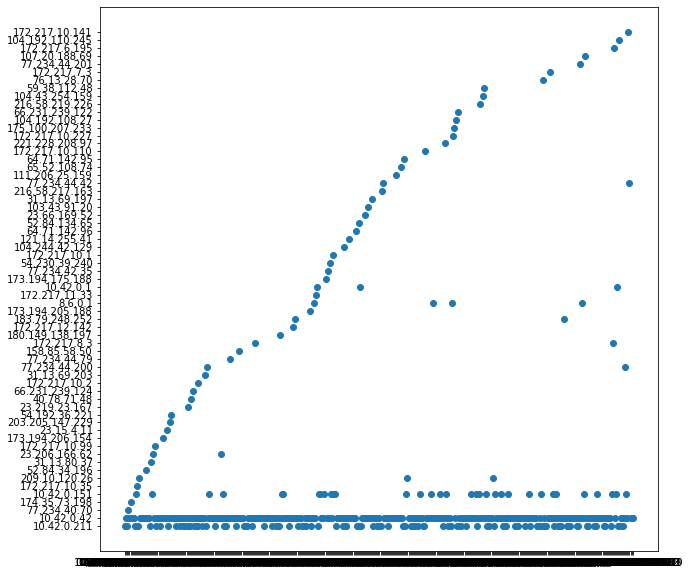

In [11]:
plt.figure(figsize=(10, 10))
plt.scatter(data.iloc[random_set]['Timestamp'], data.iloc[random_set]['SourceIP'])
pass

### Зависимость класса от времени

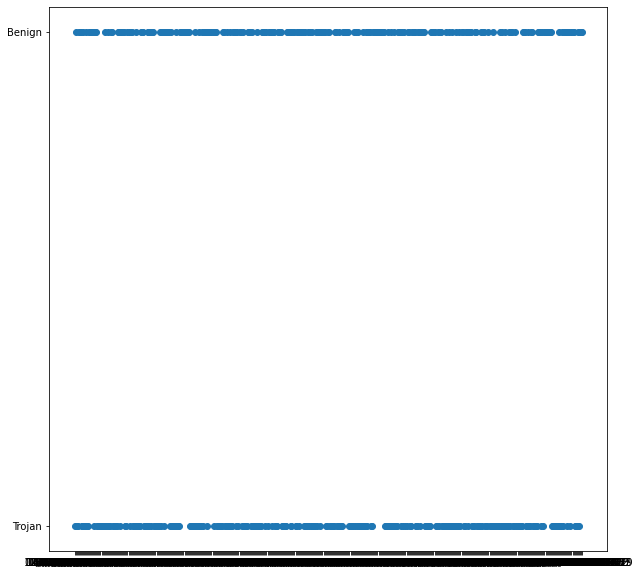

In [12]:
plt.figure(figsize=(10, 10))
plt.scatter(data.iloc[random_set]['Timestamp'], data.iloc[random_set]['Class'])
pass

### Зависимость класса от порта

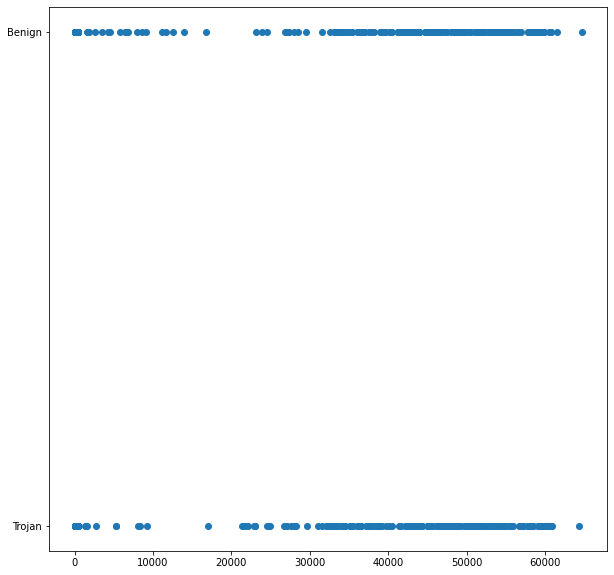

In [13]:
plt.figure(figsize=(10, 10))
plt.scatter(data.iloc[random_set]['SourcePort'], data.iloc[random_set]['Class'])
pass

### Зависимость класса от IP

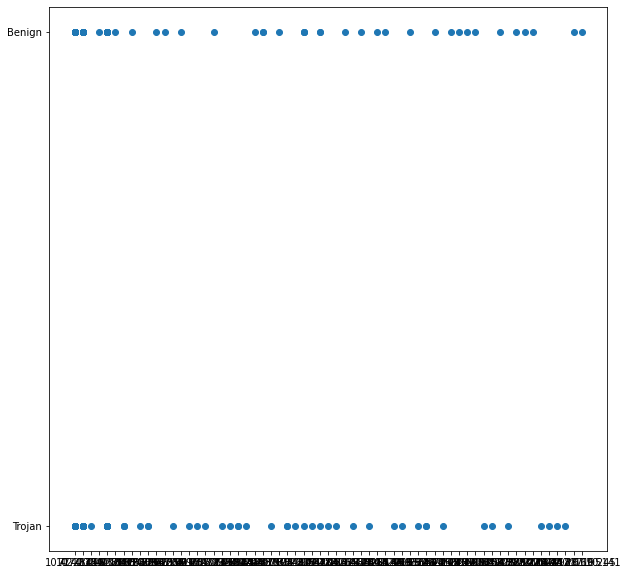

In [14]:
plt.figure(figsize=(10, 10))
plt.scatter(data.iloc[random_set]['SourceIP'], data.iloc[random_set]['Class'])
pass

### Основные характеристики

In [15]:
data.describe()

,SourcePort,DestinationPort,Protocol,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,...,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin
count,177482.000000,177482.000000,177482.000000,1.774820e+05,177482.000000,177482.000000,177482.000000,1.774820e+05,177482.000000,177482.000000,...,177482.000000,177482.000000,1.774820e+05,1.774820e+05,1.774820e+05,1.774820e+05,1.774820e+05,1.774820e+05,1.774820e+05,1.774820e+05
mean,38633.298729,5763.328969,8.295917,1.163310e+07,6.743929,9.908261,811.919496,1.023884e+04,230.168969,13.323571,...,1.673894,27.802025,1.421356e+05,2.047529e+04,1.617342e+05,1.264388e+05,4.540725e+06,4.024527e+05,4.894188e+06,4.234695e+06
std,18435.832044,15155.981517,4.540501,2.302798e+07,29.655515,106.401351,6055.745405,1.517666e+05,392.025958,67.749335,...,6.848561,6.652046,7.798898e+05,2.469821e+05,8.791481e+05,7.506803e+05,1.542957e+07,3.246955e+06,1.627581e+07,1.504980e+07
min,0.000000,0.000000,0.000000,2.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,-1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,34156.000000,80.000000,6.000000,4.690050e+04,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,43105.500000,443.000000,6.000000,4.854025e+05,2.000000,1.000000,31.000000,3.100000e+01,31.000000,0.000000,...,0.000000,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,52135.000000,443.000000,6.000000,1.062035e+07,5.000000,4.000000,451.000000,4.950000e+02,355.000000,21.000000,...,1.000000,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,65530.000000,65267.000000,17.000000,1.199991e+08,4502.000000,12951.000000,846614.000000,1.868497e+07,1460.000000,1460.000000,...,586.000000,60.000000,3.059421e+07,1.993857e+07,4.902243e+07,3.059421e+07,1.197736e+08,7.445182e+07,1.197736e+08,1.197736e+08


Из характеристик видно, что разброс данных по мин и макс очень большой, следовательно, необходима нормализация.

### Матрица корреляций

In [16]:
corr_mat=data.corr()
corr_mat

,SourcePort,DestinationPort,Protocol,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,...,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin
SourcePort,1.000000,-0.710282,-0.096631,0.126908,0.072241,0.032071,0.050839,0.025588,0.211155,-0.074645,...,0.092473,0.003277,0.068427,0.014634,0.063973,0.067352,0.066704,0.019887,0.066310,0.065807
DestinationPort,-0.710282,1.000000,-0.165186,-0.135386,-0.059508,-0.028456,-0.038100,-0.024242,-0.163946,0.037698,...,-0.067539,0.037283,-0.051000,-0.007334,-0.046767,-0.051467,-0.066280,-0.028509,-0.067513,-0.063390
Protocol,-0.096631,-0.165186,1.000000,-0.262353,-0.070046,-0.032686,-0.008224,-0.027739,-0.096863,0.179104,...,0.003692,0.175507,-0.072723,-0.035399,-0.073811,-0.066391,-0.151297,-0.071862,-0.155908,-0.143147
FlowDuration,0.126908,-0.135386,-0.262353,1.000000,0.123910,0.050607,0.089637,0.033185,0.238786,-0.038737,...,0.171774,-0.125844,0.325913,0.267515,0.364715,0.269939,0.733758,0.396360,0.766697,0.685770
TotalFwdPackets,0.072241,-0.059508,-0.070046,0.123910,1.000000,0.903120,0.239152,0.887999,0.215734,-0.026928,...,0.412126,-0.003054,0.156835,0.108562,0.167851,0.135763,0.096512,0.066071,0.103657,0.088171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ActiveMin,0.067352,-0.051467,-0.066391,0.269939,0.135763,0.075404,0.103488,0.062156,0.181945,0.061742,...,0.176732,0.011355,0.970865,0.034935,0.869774,1.000000,0.335270,0.103926,0.336218,0.326536
IdleMean,0.066704,-0.066280,-0.151297,0.733758,0.096512,0.033756,0.068327,0.018233,0.258082,-0.034394,...,0.149393,-0.012181,0.351814,0.121235,0.342233,0.335270,1.000000,0.231480,0.986114,0.987635
IdleStd,0.019887,-0.028509,-0.071862,0.396360,0.066071,0.020454,0.075579,0.008145,0.144475,0.036467,...,0.126240,0.005829,0.194386,0.393645,0.270594,0.103926,0.231480,1.000000,0.384021,0.078374
IdleMax,0.066310,-0.067513,-0.155908,0.766697,0.103657,0.035625,0.078558,0.018564,0.269149,-0.022404,...,0.166554,-0.010868,0.369307,0.188704,0.375905,0.336218,0.986114,0.384021,1.000000,0.949150


### Корреляции графическом виде

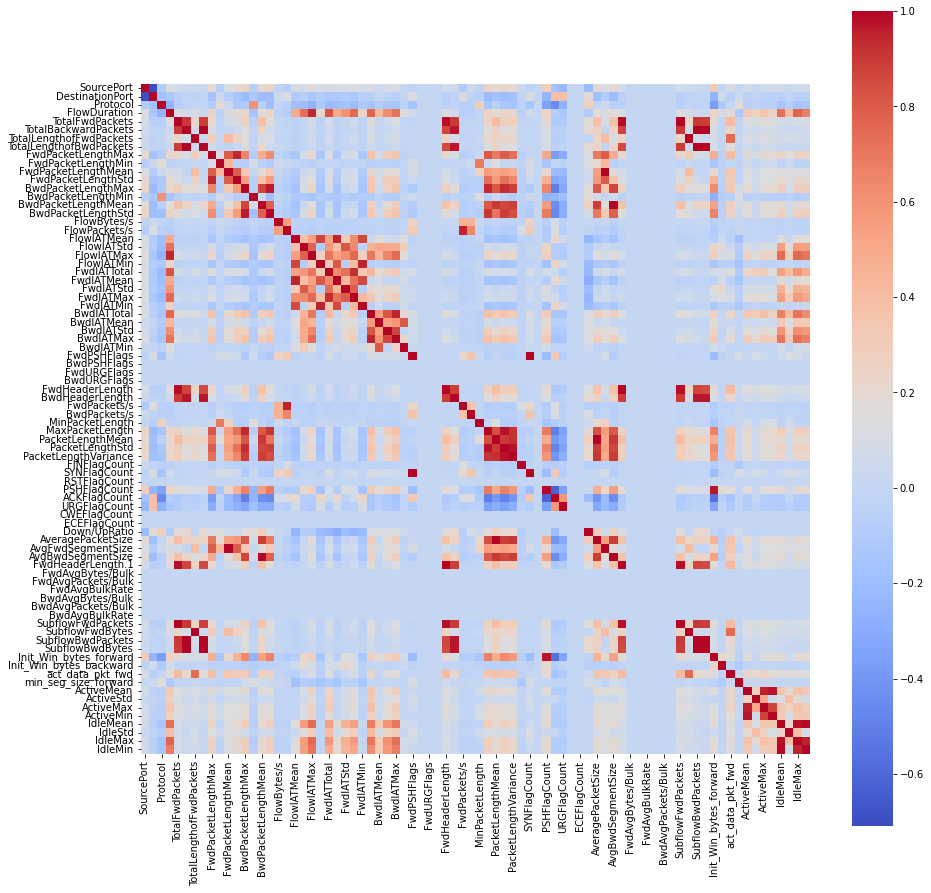

In [17]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr_mat.fillna(0.0), square=True, cmap='coolwarm')
pass

В основном корреллируют характеристики, относящиеся к размерным и скоростным характеристикам пакетов.

### Можно посмотреть в таком виде

In [18]:
abs(corr_mat) > 0.9

,SourcePort,DestinationPort,Protocol,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,...,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin
SourcePort,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
DestinationPort,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Protocol,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
FlowDuration,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
TotalFwdPackets,False,False,False,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ActiveMin,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
IdleMean,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,True
IdleStd,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
IdleMax,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,True


## Обработка пропущенных значений

In [19]:
data.isna().sum()

FlowID             0
SourceIP           0
SourcePort         0
DestinationIP      0
DestinationPort    0
                  ..
IdleMean           0
IdleStd            0
IdleMax            0
IdleMin            0
Class              0
Length: 85, dtype: int64

In [20]:
data.isna().sum().sum()

0

=> Пропущенные значения отсутствуют

## Обработка текстовых данных

In [21]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
categorical_columns

['FlowID', 'SourceIP', 'DestinationIP', 'Timestamp', 'Class']

Каждое значение преобразуется в число. В данной задаче использование LabelEncoder оптимальнее OneHotEncoder. OneHotEncoder не подходит т.к. в датасете имеется большое количество уникальных данных, что приводит к созданию более чем 19 000 новых булевых признаков.

In [22]:
from sklearn import preprocessing

data_describe = data.describe(include = [object])

number = preprocessing.LabelEncoder()

data["FlowID"] = number.fit_transform(data["FlowID"])
data["SourceIP"] = number.fit_transform(data["SourceIP"])
data["DestinationIP"] = number.fit_transform(data["DestinationIP"])
# !!!
data["Timestamp"] = number.fit_transform(data["Timestamp"])

In [23]:
numerical_columns = [c for c in data.columns if data[c].dtype.name != 'object']
len(numerical_columns)

84

In [24]:
binary_columns = [c for c in categorical_columns if data_describe[c]['unique'] == 2]

In [25]:
data['Class'].unique()

array(['Trojan', 'Benign'], dtype=object)

In [26]:
data.at[data['Class'] == 'Trojan', 'Class'] = 1
data.at[data['Class'] == 'Benign', 'Class'] = 0
data['Class'].describe()

count     177482
unique         2
top            1
freq       90683
Name: Class, dtype: int64

## Нормализация числовых данных

Как было отмечено выше, датасет имеет сильный разброс по мин и макс данным в столбцах, что может негативно сказаться на обучении.  
Необходимо нормализовать данные, т.е. привести их к отрезку [-1;1]

In [27]:
data_numerical = data[numerical_columns].astype('float32')

In [28]:
data_numerical.std(axis = 0)

FlowID             2.614904e+04
SourceIP           3.255239e+02
SourcePort         1.843583e+04
DestinationIP      9.059336e+02
DestinationPort    1.515598e+04
                       ...     
ActiveMin          7.506802e+05
IdleMean           1.542957e+07
IdleStd            3.246955e+06
IdleMax            1.627581e+07
IdleMin            1.504980e+07
Length: 84, dtype: float32

In [29]:
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)
data_numerical = data_numerical.fillna(0.0)

## Соединение всех данных

Нужно объединить данные, которые обрабатывались отдельно.

In [30]:
data = pd.concat((data_numerical, data[binary_columns]), axis = 1)
data.shape

(177482, 85)

In [31]:
data.head()

,FlowID,SourceIP,SourcePort,DestinationIP,DestinationPort,Protocol,Timestamp,FlowDuration,TotalFwdPackets,TotalBackwardPackets,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Class
73217,-0.254680,-0.301850,0.615199,-0.551040,-0.374989,-0.505653,1.285073,-0.038628,-0.092527,-0.055528,...,-1.172876,-0.182251,-0.082902,-0.183967,-0.168432,-0.294287,-0.123948,-0.300703,-0.281379,1
72089,0.846469,-0.301850,0.571479,0.048341,-0.351038,1.916987,1.531425,-0.494133,-0.025086,-0.027333,...,-1.172876,-0.182251,-0.082902,-0.183967,-0.168432,-0.294287,-0.123948,-0.300703,-0.281379,1
96676,-1.665593,-0.301850,-0.047966,-0.931863,-0.376771,1.916987,1.765842,-0.460738,-0.193688,-0.083723,...,0.631080,-0.182251,-0.082902,-0.183967,-0.168432,-0.294287,-0.123948,-0.300703,-0.281379,0
42891,-1.619663,-0.301850,0.147468,-0.931863,-0.376771,1.916987,0.755896,-0.492732,-0.193688,-0.083723,...,-1.172876,-0.182251,-0.082902,-0.183967,-0.168432,-0.294287,-0.123948,-0.300703,-0.281379,1
169326,-1.224047,-0.307994,0.310249,-0.696746,-0.351038,-0.505653,-0.346225,2.344973,0.177238,0.000862,...,0.631080,0.231390,-0.082902,0.182972,0.261303,3.614245,-0.123948,3.404611,3.725784,0


## Разбиение данных для обучения и тестов

In [32]:
X = data.drop('Class', axis = 1)
y = data['Class']

In [33]:
X = X.to_numpy()
y = np.array(y, dtype='int')

In [34]:
X.shape

(177482, 84)

In [35]:
y.shape

(177482,)

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

124237 53245


## Метод K ближайших соседей, подбор n_neighbors

Т.к. перебирать число соседей очень долго, попробуем угадать вручную.

### KNN, 15 соседей

In [37]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 15)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15)

**Ошибки на тестовой выборке**

In [38]:
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)
err_test

0.06366795004225749

In [39]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_test_predict))

[[24018  2056]
 [ 1334 25837]]


In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93     26074
           1       0.93      0.95      0.94     27171

    accuracy                           0.94     53245
   macro avg       0.94      0.94      0.94     53245
weighted avg       0.94      0.94      0.94     53245



**Ошибки на тренировочной выборке**

In [41]:
y_train_predict = knn.predict(X_train)
err_train  = np.mean(y_train  != y_train_predict)
err_train

0.05344623582346644

In [42]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_train, y_train_predict))

[[56621  4104]
 [ 2536 60976]]


In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_predict))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94     60725
           1       0.94      0.96      0.95     63512

    accuracy                           0.95    124237
   macro avg       0.95      0.95      0.95    124237
weighted avg       0.95      0.95      0.95    124237



### KNN, 20 соседей

In [44]:
knn = KNeighborsClassifier(n_neighbors = 20)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

**Ошибки на тестовой выборке**

In [45]:
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)
err_test

0.06639121044229505

In [46]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_test_predict))

[[24074  2000]
 [ 1535 25636]]


In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     26074
           1       0.93      0.94      0.94     27171

    accuracy                           0.93     53245
   macro avg       0.93      0.93      0.93     53245
weighted avg       0.93      0.93      0.93     53245



**Ошибки на тренировочной выборке**

In [48]:
y_train_predict = knn.predict(X_train)
err_train  = np.mean(y_train  != y_train_predict)
err_train

0.0585010906573726

In [49]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_train, y_train_predict))

[[56546  4179]
 [ 3089 60423]]


In [50]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_predict))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94     60725
           1       0.94      0.95      0.94     63512

    accuracy                           0.94    124237
   macro avg       0.94      0.94      0.94    124237
weighted avg       0.94      0.94      0.94    124237



### KNN, 5 соседей

In [51]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

**Ошибки на тестовой выборке**

In [52]:
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)
err_test

0.054164710301436755

In [53]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_test_predict))

[[24418  1656]
 [ 1228 25943]]


In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94     26074
           1       0.94      0.95      0.95     27171

    accuracy                           0.95     53245
   macro avg       0.95      0.95      0.95     53245
weighted avg       0.95      0.95      0.95     53245



**Ошибки на тренировочной выборке**

In [55]:
y_train_predict = knn.predict(X_train)
err_train  = np.mean(y_train  != y_train_predict)
err_train

0.03292094947559906

In [56]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_train, y_train_predict))

[[58305  2420]
 [ 1670 61842]]


In [57]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_predict))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97     60725
           1       0.96      0.97      0.97     63512

    accuracy                           0.97    124237
   macro avg       0.97      0.97      0.97    124237
weighted avg       0.97      0.97      0.97    124237



### KNN, 10 соседей

In [58]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

**Ошибки на тестовой выборке**

In [59]:
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)
err_test

0.06021222650014086

In [60]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_test_predict))

[[24474  1600]
 [ 1606 25565]]


In [61]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     26074
           1       0.94      0.94      0.94     27171

    accuracy                           0.94     53245
   macro avg       0.94      0.94      0.94     53245
weighted avg       0.94      0.94      0.94     53245



**Ошибки на тренировочной выборке**

In [62]:
y_train_predict = knn.predict(X_train)
err_train  = np.mean(y_train  != y_train_predict)
err_train

0.046137624057245426

In [63]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_train, y_train_predict))

[[57918  2807]
 [ 2925 60587]]


In [64]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_predict))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     60725
           1       0.96      0.95      0.95     63512

    accuracy                           0.95    124237
   macro avg       0.95      0.95      0.95    124237
weighted avg       0.95      0.95      0.95    124237



### Результаты KNN

В итоге экспериментов получились следующие результаты  

| Число соседей | Ошибка на тестах | Ошибка на обучении |
| --- | --- | --- |
| 5 | 0.054 | 0.033 |
| 10 | 0.060 | 0.046 |
| 15 | 0.063 | 0.053 |
| 20 | 0.066 | 0.058 |

При небольшом числе соседей алгоритм работает точнее. Это может быть связано с тем, что датасет содержит очень много данных. В таком случае с большой вероятностью могут быть найдены очень близкие соседние элементы, у которых личный класс практически полностью совпадает со средним. Увеличение числа соседей приводит к смещению среднего класса в неверную сторону.

В целом, метод ближайших соседей показал отличную точность.

## RandomForest

Для сравнения рассмотрим алгоритм случайного леса, который заключается в использовании ансамбля деревьев решений.

In [65]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators = 1000)
rf.fit(X_train, y_train)

err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))

print(err_train, err_test)

0.0 0.0021786083200300496


### Результаты RandomForest
Точность данного алгоритма лучше, чем у метода ближайших соседей, однако, на мой взгляд время обучения в данном случае слишком большое.

## Выводы

В данной работе я рассмотрел задачу о классификации сетевого трафика на вирусный и безопасный. В процессе анилиза данных я попытался виделить признаки, которые вносят основной вклад в классификацию - ip, port, timestamp, длины пакетов. Но в целом, не менее важны и остальные признаки, без которых невозможно достичь высокой точности.  

Благодаря большому числу признаков и записей в датасете, мне удалось получить высокую точность даже на самом простом алгоритме - методе ближайших соседей.  

Для сравнения я использовал метод случайного леса, основанный на ансамбле деревьев решений. Данный метод показал неплохой прирост точности по сравнению с методом ближайших соседей, но из-за этого он требует большого времени обучения. 

